## Predicting Song Popularities with RF & XGBoost

#### For this assignment, we are tasked with building a classification model that can predict a track's popularity into binned categorical variables based on many features.


#### Here are the steps we followed in this analysis:

* [Data Exploration](#explore)
* [Data Processing](#processing)
* [Random Forest model](#rf)
* [XGBoost model](#xgb)

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from scipy import stats
import math
import ast

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

import xgboost as xgb
from xgboost import XGBClassifier


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Exploration <a id="explore"></a>

In [2]:
songs = pd.read_excel("Songs_2024.xlsx", sheet_name='spotify songs')
songs.head()

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,2000,Yellow,91,Parachutes,Coldplay,['permanent wave'; 'pop'],86,0.429,0.661,11.0,85.0,1.0,0.0281,0.00239,0.000121,0.2340,0.285,173.372,266773.0
1,2000,All The Small Things,84,Enema Of The State,blink-182,['alternative metal'; 'modern rock'; 'pop punk...,75,0.434,0.897,0.0,69.0,1.0,0.0488,0.01030,0.000000,0.6120,0.684,148.726,167067.0
2,2000,Breathe,69,Breathe,Faith Hill,['contemporary country'; 'country'; 'country d...,61,0.529,0.496,7.0,95.0,1.0,0.0290,0.17300,0.000000,0.2510,0.278,136.859,250547.0
3,2000,In the End,88,Hybrid Theory (Bonus Edition),Linkin Park,['alternative metal'; 'nu metal'; 'post-grunge...,83,0.556,0.864,3.0,76.0,0.0,0.0584,0.00958,0.000000,0.2090,0.400,105.143,216880.0
4,2000,Bye Bye Bye,74,No Strings Attached,*NSYNC,['boy band'; 'dance pop'; 'pop'],65,0.610,0.926,8.0,68.0,0.0,0.0479,0.03100,0.001200,0.0821,0.861,172.638,200400.0


In [3]:
songs.describe()

,year,track_popularity,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,2300.000000,2300.000000,2300.000000,2299.000000,2299.000000,2299.000000,2299.000000,2299.000000,2299.000000,2299.000000,2299.000000,2299.000000,2299.000000,2299.000000,2299.000000
mean,2011.000000,70.943478,72.869565,0.660116,0.693047,5.277947,73.006960,0.598521,0.097795,0.157689,0.013766,0.172618,0.535110,120.512450,226033.494128
std,6.634692,12.291526,12.179263,0.141137,0.164838,3.628494,15.643937,0.490304,0.092445,0.203844,0.083990,0.131620,0.227821,27.617729,42063.678588
min,2000.000000,0.000000,29.000000,0.162000,0.051900,0.000000,-56.000000,0.000000,0.022500,0.000013,0.000000,0.021000,0.037700,60.019000,97393.000000
25%,2005.000000,66.000000,65.000000,0.572000,0.586000,2.000000,63.000000,0.000000,0.038000,0.016500,0.000000,0.089950,0.360500,98.569500,200179.500000
50%,2011.000000,72.000000,74.000000,0.671000,0.712000,5.000000,74.000000,1.000000,0.056800,0.068900,0.000000,0.119000,0.540000,120.000000,221653.000000
75%,2017.000000,79.000000,82.000000,0.759500,0.820000,8.000000,83.000000,1.000000,0.115500,0.223000,0.000054,0.220000,0.722000,137.028000,245950.000000
max,2022.000000,100.000000,100.000000,0.975000,0.999000,11.000000,132.000000,1.000000,0.576000,0.978000,0.985000,0.843000,0.974000,210.857000,688453.000000


In [4]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300 entries, 0 to 2299
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               2300 non-null   int64  
 1   track_name         2300 non-null   object 
 2   track_popularity   2300 non-null   int64  
 3   album              2300 non-null   object 
 4   artist_name        2300 non-null   object 
 5   artist_genres      2300 non-null   object 
 6   artist_popularity  2300 non-null   int64  
 7   danceability       2299 non-null   float64
 8   energy             2299 non-null   float64
 9   key                2299 non-null   float64
 10  loudness           2299 non-null   float64
 11  mode               2299 non-null   float64
 12  speechiness        2299 non-null   float64
 13  acousticness       2299 non-null   float64
 14  instrumentalness   2299 non-null   float64
 15  liveness           2299 non-null   float64
 16  valence            2299 

In [5]:
#Checking number of unique rows in each feature
songs.nunique().sort_values()

mode                    2
key                    12
year                   23
artist_popularity      62
track_popularity       71
loudness              104
danceability          585
energy                641
artist_genres         698
liveness              807
valence               827
instrumentalness      841
speechiness           860
artist_name           891
acousticness         1322
album                1663
duration_ms          2033
tempo                2074
track_name           2121
dtype: int64

In [6]:
# visualizing missing rows as numpy array for ease
missing_rows = songs[songs.isnull().any(axis=1)].to_numpy()

# Display the rows with missing values
print(missing_rows)

[[2004 'These Words' 68 'Unwritten' 'Natasha Bedingfield'
  "['dance pop'; 'pop'; 'post-teen pop']" 64 nan nan nan nan nan nan nan
  nan nan nan nan nan]]


In [7]:
songs.isnull().sum()

year                 0
track_name           0
track_popularity     0
album                0
artist_name          0
artist_genres        0
artist_popularity    0
danceability         1
energy               1
key                  1
loudness             1
mode                 1
speechiness          1
acousticness         1
instrumentalness     1
liveness             1
valence              1
tempo                1
duration_ms          1
dtype: int64

In [8]:
# Dealing with missing values and duplicates 
songs = songs.drop_duplicates(subset=['track_name','artist_name']) #Bare in mind that we can have songs with the same name but different artists, so we are not removing those.


for column in songs.columns:
    if songs[column].isna().any() and songs[column].dtype != 'object':
    # Fill null values with the mean 
        songs[column].fillna(songs[column].mean(), inplace=True)

In [9]:
songs.isnull().sum()

year                 0
track_name           0
track_popularity     0
album                0
artist_name          0
artist_genres        0
artist_popularity    0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
dtype: int64

In [10]:
# choosing the metric variables to check outlier counts
columns_to_check = ['year','track_popularity','artist_popularity','danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms']

def detect_outliers_iqr(data, column):
    """
    Detects outliers in a dataframe column based on the IQR method.
    
    Parameters:
    - data: pandas DataFrame.
    - column: String name of the column to check for outliers.
    
    Returns:
    - DataFrame containing the outliers.
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    # 5 is a high value to check for drastic outliers
    lower_bound = Q1 - 5 * IQR 
    upper_bound = Q3 + 5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

def detect_outliers_zscore(data, column, threshold=3):
    """
    Detects outliers in a dataframe column based on the Z-score method.
    
    Parameters:
    - data: pandas DataFrame.
    - column: String name of the column to check for outliers.
    - threshold: Z-score threshold for considering a point as an outlier.
    
    Returns:
    - DataFrame containing the outliers.
    """
    z_scores = stats.zscore(data[column])
    return data[abs(z_scores) > threshold]

outliers_count_z = {}
outliers_count_iqr = {}

# Looping through the columns to check for outliers
for column in columns_to_check:
    outliers_iqr = detect_outliers_iqr(songs, column)
    outliers_z = detect_outliers_zscore(songs, column)
    outliers_count_z[column] = len(outliers_iqr)
    outliers_count_iqr[column] = len(outliers_z)

# Creating DataFrames for Z-score and IQR outlier counts
df_outliers_z = pd.DataFrame(list(outliers_count_z.items()), columns=['Column', 'Outliers_Z'])
df_outliers_iqr = pd.DataFrame(list(outliers_count_iqr.items()), columns=['Column', 'Outliers_IQR'])

# Merging the two DataFrames on the 'Column' column
df_outliers = pd.merge(df_outliers_z, df_outliers_iqr, on='Column')

print(df_outliers)

               Column  Outliers_Z  Outliers_IQR
0                year           0             0
1    track_popularity           0            38
2   artist_popularity           0             7
3        danceability           0             9
4              energy           0            13
5                 key           0             0
6            loudness           1            16
7                mode           0             0
8         speechiness           2            40
9        acousticness           0            56
10   instrumentalness         375            36
11           liveness           0            60
12            valence           0             0
13              tempo           0             6
14        duration_ms           3            17


In [11]:
# Replace semicolons with commas in the 'artist_genres' column before applying ast.literal_eval
songs['artist_genres'] = songs['artist_genres'].apply(lambda x: x.replace(';', ',') if isinstance(x, str) else x)

# Now safely apply ast.literal_eval to convert string representations of lists into actual lists
songs['artist_genres'] = songs['artist_genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

songs = songs.dropna(subset=['artist_genres'])

# Flatten the list of genres from all rows into a single list
all_genres = sum(songs['artist_genres'], [])

# Convert the list to a set to remove duplicates, then count the unique elements
unique_genres = set(all_genres)
number_of_unique_genres = len(unique_genres)

print(f"There are {number_of_unique_genres} unique genres in the dataset.")


There are 437 unique genres in the dataset.


### Experimenting with Genre

In [12]:
# Normalize genre names: lowercase and remove special characters if necessary
songs['artist_genres'] = ["".join(x).lower().replace('[^a-z\s]', '') for x in songs['artist_genres']]

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=1000)

# Fit and transform the genre names
genre_tfidf = tfidf.fit_transform(songs['artist_genres'])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
songs['genre_cluster'] = kmeans.fit_predict(genre_tfidf)

# Display the number of genres per cluster to check the distribution
print(songs['genre_cluster'].value_counts())

genre_cluster
2    946
7    260
1    238
8    168
3    154
9    132
0    107
5     89
6     49
4     38
Name: count, dtype: int64


In [13]:
# For simplicity, let's see some examples of genres in each cluster
for cluster in sorted(songs['genre_cluster'].unique()):
    print(f"Cluster {cluster}:")
    examples = songs[songs['genre_cluster'] == cluster]['artist_genres'].unique()
    print(examples[:5])  # Print 5 examples per cluster


Cluster 0:
['detroit hip hophip hoprap'
 'east coast hip hopgangster raphip hoppop raprap'
 'east coast hip hopgangster raphardcore hip hophip hoprap'
 'detroit hip hopgangster raphip hop'
 'dance popeast coast hip hopgangster raphip hophip poppop rapqueens hip hoprapurban contemporary']
Cluster 1:
['pop rock' 'canadian pop' 'dance pop' 'hip pop' 'pop']
Cluster 2:
['permanent wavepop' 'boy banddance poppop' 'dance rockeuropop'
 'disco housefilter house' 'bouncy houseeurodance']
Cluster 3:
['dance poppop' 'canadian poppop' 'hip poppop' 'poppop r&b'
 'dance poppop danceuk dance']
Cluster 4:
['popsinger-songwriter popuk pop' 'popuk pop' 'popuk danceuk funky']
Cluster 5:
['g funkgangster raphip hoprapwest coast rap' 'comedy rap' 'rap rock'
 'dance popdancehallpoppop rap' 'dance poppoppop rap']
Cluster 6:
['contemporary r&bhip popr&b'
 'dance popr&bsouthern hip hopurban contemporary' 'popr&b'
 'hip popr&bsouthern hip hopurban contemporary'
 'contemporary r&bdirty south raphip popr&bsouthern

In [14]:
cluster_labels = {
    0: 'Urban Hip Hop',
    1: 'Mainstream Pop',
    2: 'Dance/Electronic',
    3: 'Contemporary R&B',
    4: 'UK Pop/Funk',
    5: 'Diverse Hip Hop',
    6: 'Modern R&B',
    7: 'Hip Hop/Rap Fusion',
    8: 'Country',
    9: 'Alt Rock/Metal Fusion'
}


In [15]:
# Map the cluster labels to the dataset
songs['genre_label'] = songs['genre_cluster'].map(cluster_labels)
print(songs[['artist_genres', 'genre_cluster', 'genre_label']].head(10))


                                       artist_genres  genre_cluster  \
0                                  permanent wavepop              2   
1  alternative metalmodern rockpop punkpunkrockso...              9   
2  contemporary countrycountrycountry dawncountry...              8   
3  alternative metalnu metalpost-grungerap metalrock              9   
4                               boy banddance poppop              2   
5  contemporary r&bdirty south raphip popr&burban...              8   
6                          detroit hip hophip hoprap              0   
7                                  dance rockeuropop              2   
8        dance popgirl grouppopr&burban contemporary              8   
9  alternative rockfunk metalfunk rockpermanent w...              9   

             genre_label  
0       Dance/Electronic  
1  Alt Rock/Metal Fusion  
2                Country  
3  Alt Rock/Metal Fusion  
4       Dance/Electronic  
5                Country  
6          Urban Hip Hop  
7 

In [16]:
songs.to_excel('genre_clustered.xlsx', index=False)

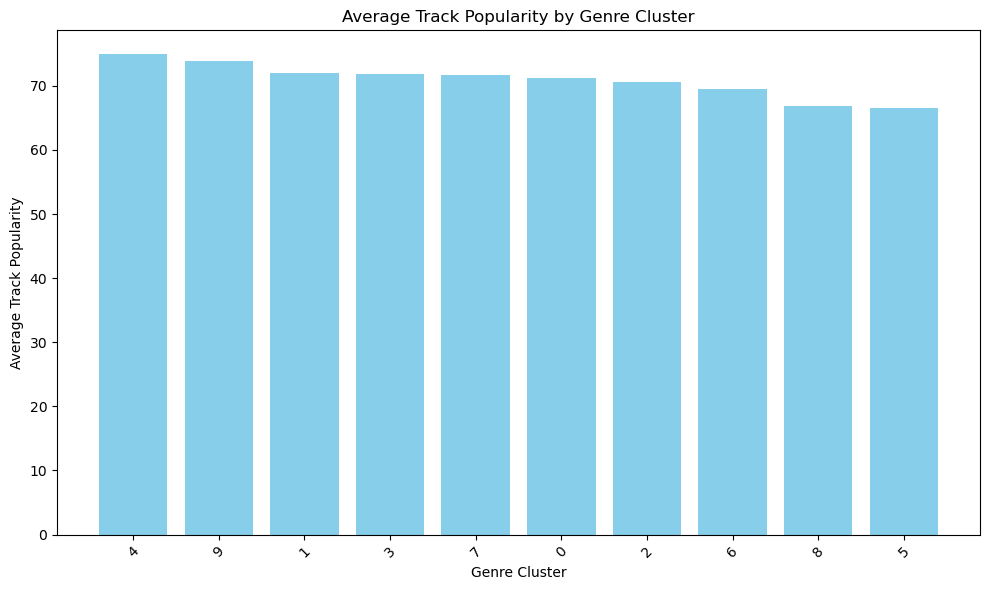

In [17]:
# Load the data
songs = pd.read_excel('genre_clustered.xlsx' )

# Calculate average track popularity for each genre cluster
avg_popularity_by_cluster = songs.groupby('genre_cluster')['track_popularity'].mean().reset_index()

# Sort the clusters for better visualization
avg_popularity_by_cluster = avg_popularity_by_cluster.sort_values(by='track_popularity', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(avg_popularity_by_cluster['genre_cluster'].astype(str), avg_popularity_by_cluster['track_popularity'], color='skyblue')
plt.xlabel('Genre Cluster')
plt.ylabel('Average Track Popularity')
plt.title('Average Track Popularity by Genre Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


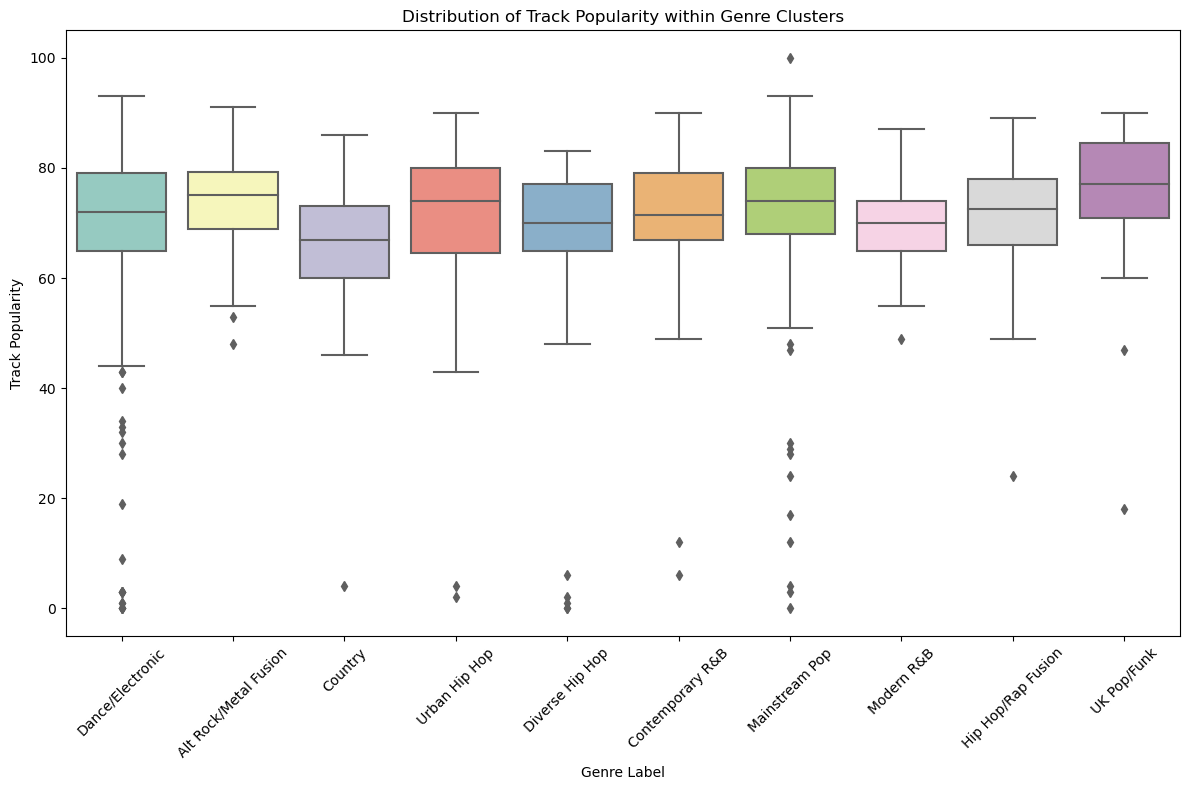

In [18]:
# Creating the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='genre_label', y='track_popularity', data=songs, palette="Set3")

plt.title('Distribution of Track Popularity within Genre Clusters')
plt.xlabel('Genre Label')
plt.ylabel('Track Popularity')
plt.xticks(rotation=45)  # Rotates the labels on the x-axis for better readability

plt.tight_layout()
plt.show()

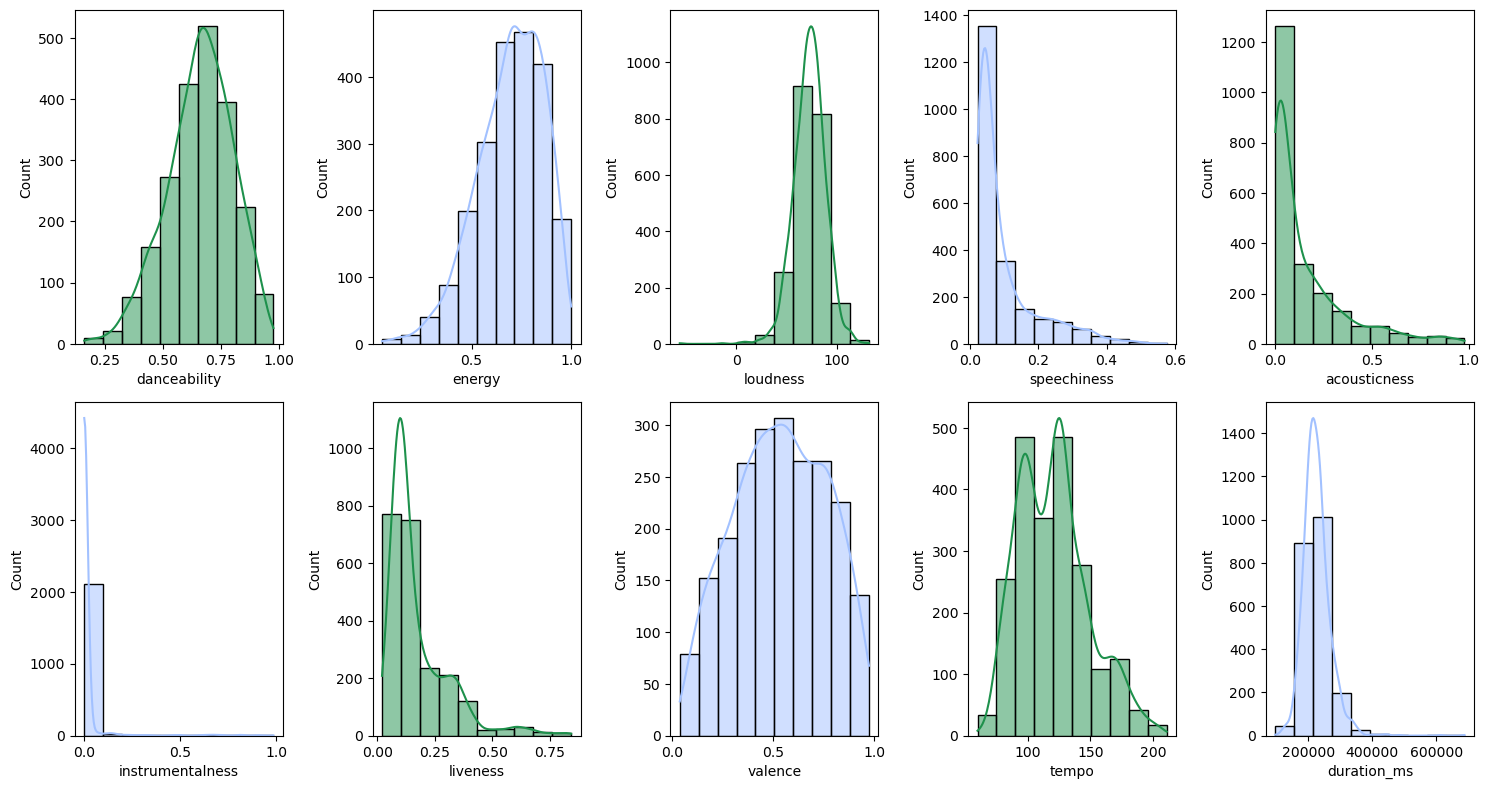

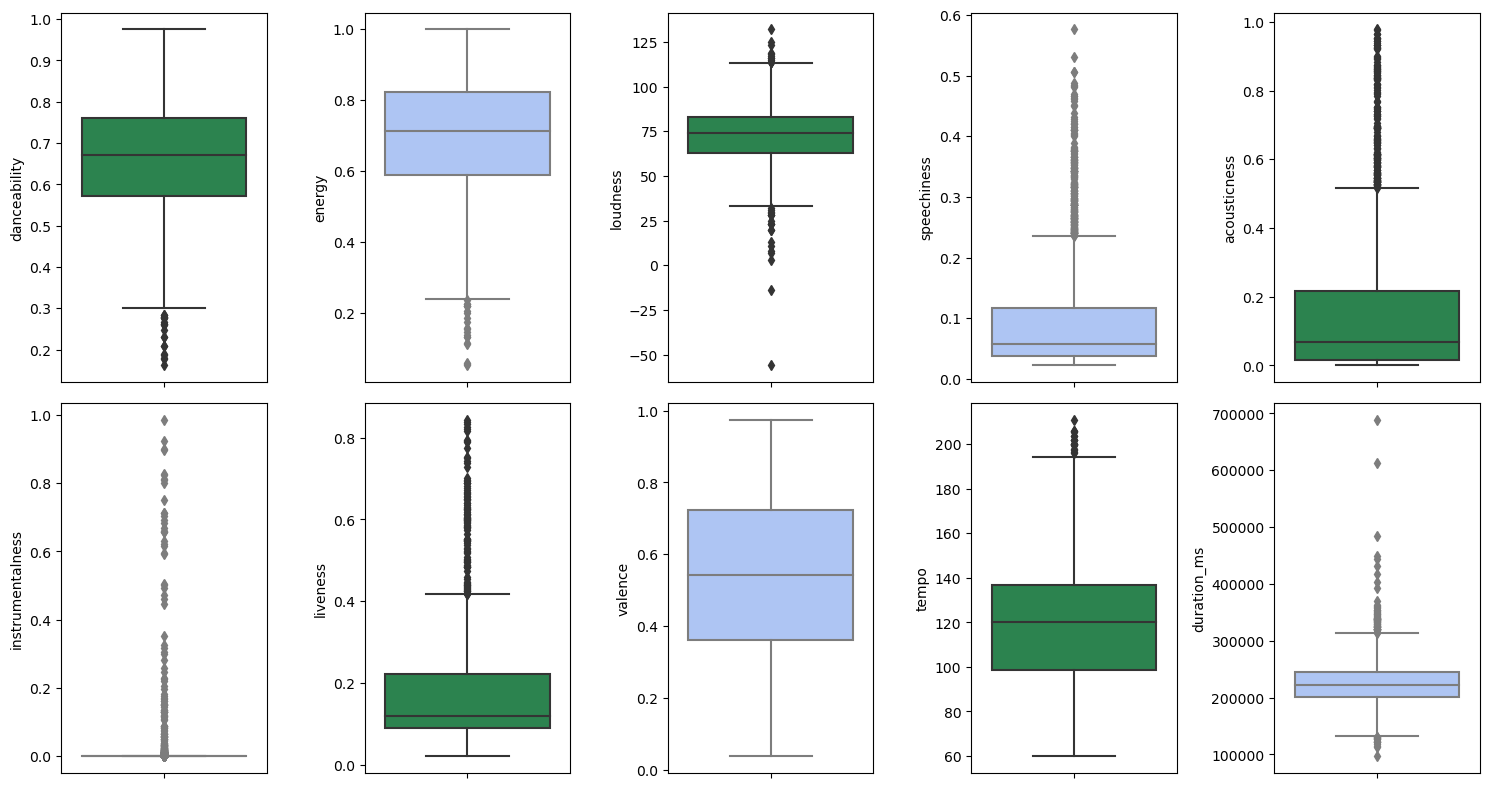

In [19]:
# list of your numerical feature column names
nf = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

n = 5  # Columns per row
rows = math.ceil(len(nf)/n)  # Number of rows needed

# Define colors to cycle between green and blue
clr = ['#1E914C', '#A2C1FF']  # using specific hex codes

# Distribution plots
plt.figure(figsize=[15, 4*rows])
for i, feature in enumerate(nf):
    plt.subplot(rows, n, i+1)
    sns.histplot(songs[feature], kde=True, color=clr[i % len(clr)], edgecolor="black", bins=10)
plt.tight_layout()
plt.show()

# Box plots
plt.figure(figsize=[15, 4*rows])
for i, feature in enumerate(nf):
    plt.subplot(rows, n, i+1)
    sns.boxplot(y=songs[feature], color=clr[i % len(clr)])
plt.tight_layout()
plt.show()


In [20]:
# Create a subplot grid: 4 rows, 2 columns, making it more compact
fig = make_subplots(rows=4, cols=2, subplot_titles=(
    'Artist Popularity over Years', 'Artist Popularity vs Track Popularity',
    'Valence vs Danceability', 'Energy vs Valence',
    'Danceability vs Energy', 'Loudness vs Acousticness (Negative Correlation)',
    'Energy vs Acousticness (Negative Correlation)'
))

# Add each scatter plot to the grid, adjust the row and col accordingly
fig.add_trace(go.Scatter(x=songs['year'], y=songs['artist_popularity'], mode='markers', marker=dict(color='#1E914C')), row=1, col=1)
fig.add_trace(go.Scatter(x=songs['artist_popularity'], y=songs['track_popularity'], mode='markers', marker=dict(color='#A2C1FF')), row=1, col=2)
fig.add_trace(go.Scatter(x=songs['valence'], y=songs['danceability'], mode='markers', marker=dict(color='#1E914C')), row=2, col=1)
fig.add_trace(go.Scatter(x=songs['energy'], y=songs['valence'], mode='markers', marker=dict(color='#A2C1FF')), row=2, col=2)
fig.add_trace(go.Scatter(x=songs['danceability'], y=songs['energy'], mode='markers', marker=dict(color='#1E914C')), row=3, col=1)
fig.add_trace(go.Scatter(x=songs['loudness'], y=songs['acousticness'], mode='markers', marker=dict(color='#A2C1FF')), row=3, col=2)
fig.add_trace(go.Scatter(x=songs['energy'], y=songs['acousticness'], mode='markers', marker=dict(color='#1E914C')), row=4, col=1)

# Since we have an odd number of plots, one subplot will be empty

# Update layout for a cleaner look
fig.update_layout(height=1200, width=800, title_text="Scatter Plots Grid", showlegend=False)
fig.show()

/var/folders/r8/9knv8vvj3m98jv1qltst72xr0000gn/T/ipykernel_72994/1722633087.py:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='track_popularity', ylabel='Density'>

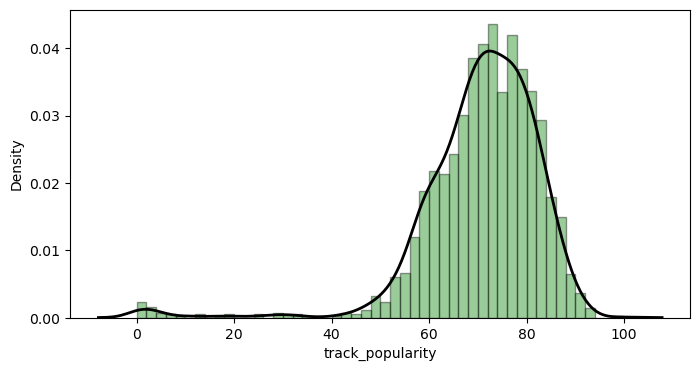

In [21]:
# Set the figure size
plt.figure(figsize=[8, 4])
# Creating graphic with seaborn using the 'track_popularity' column
sns.distplot(songs['track_popularity'], color='g', kde_kws={"color": "k", "lw": 2}, hist_kws={"edgecolor": "black", "linewidth": 1}, bins=50)
# Establecer el título del gráfico

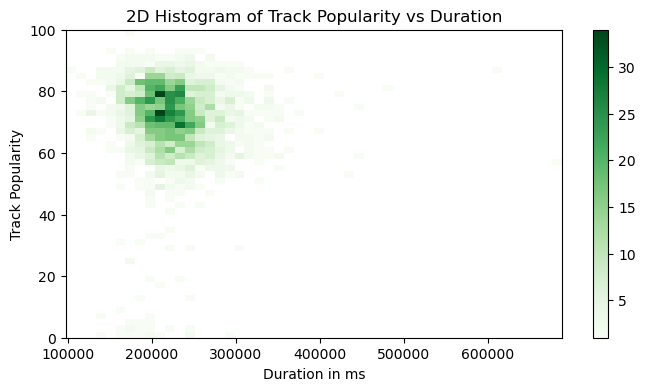

In [22]:
plt.figure(figsize=[8, 4])
plt.hist2d(songs['duration_ms'], songs['track_popularity'], bins=[50, 50], cmap='Greens', cmin=1)
plt.xlabel('Duration in ms')
plt.ylabel('Track Popularity')
plt.title('2D Histogram of Track Popularity vs Duration')
plt.colorbar()
plt.show()

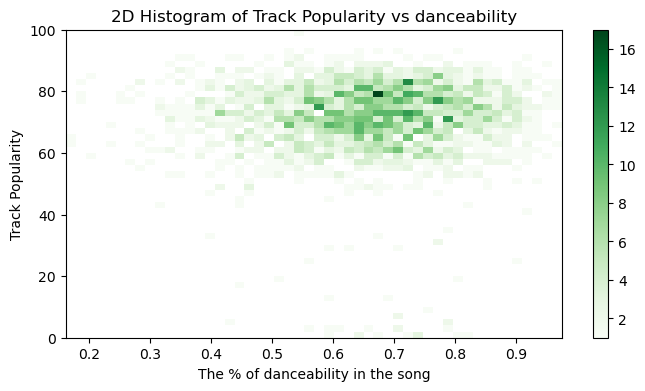

In [23]:
plt.figure(figsize=[8, 4])
plt.hist2d(songs['danceability'], songs['track_popularity'], bins=[50, 50], cmap='Greens', cmin=1)
plt.xlabel('The % of danceability in the song')
plt.ylabel('Track Popularity')
plt.title('2D Histogram of Track Popularity vs danceability')
plt.colorbar()
plt.show()

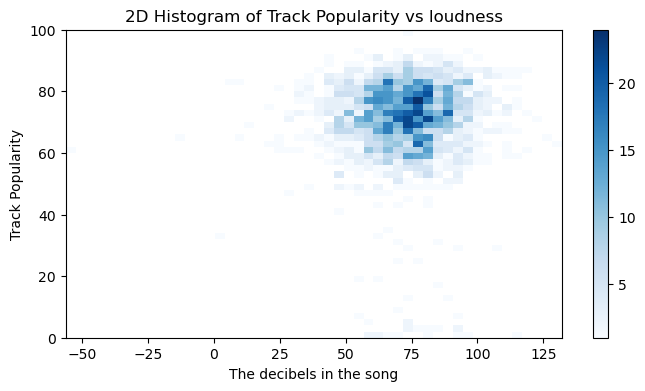

In [24]:
# Ajustar el tamaño de la figura con matplotlib
plt.figure(figsize=[8, 4])
plt.hist2d(songs['loudness'], songs['track_popularity'], bins=[50, 50], cmap='Blues', cmin=1)
plt.xlabel('The decibels in the song')
plt.ylabel('Track Popularity')
plt.title('2D Histogram of Track Popularity vs loudness')
plt.colorbar()
plt.show()

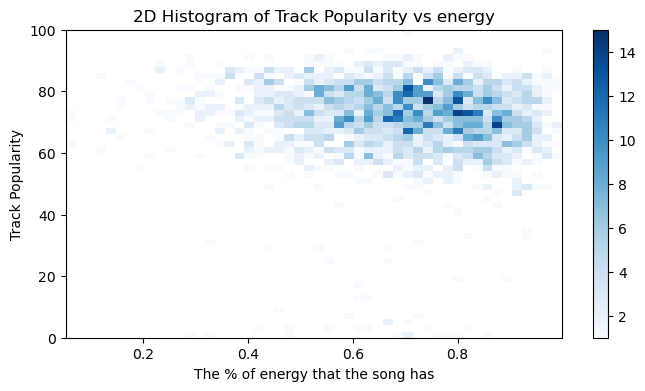

In [25]:
# Ajustar el tamaño de la figura con matplotlib
plt.figure(figsize=[8, 4])


plt.hist2d(songs['energy'], songs['track_popularity'], bins=[50, 50], cmap='Blues', cmin=1)
plt.xlabel('The % of energy that the song has')
plt.ylabel('Track Popularity')
plt.title('2D Histogram of Track Popularity vs energy')
plt.colorbar()
plt.show()

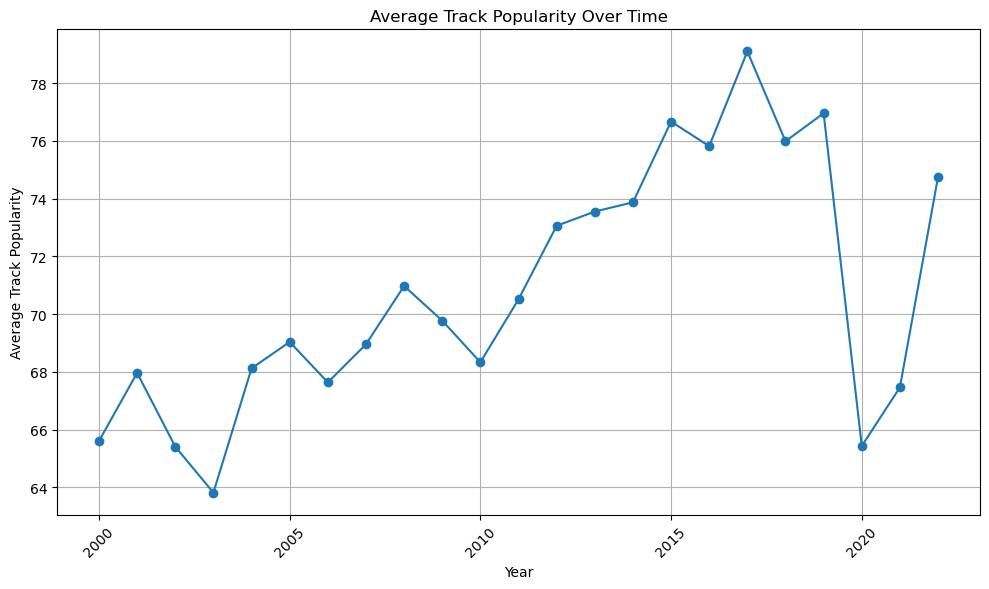

In [26]:

# Step 2: Group the data by year and calculate the average track popularity
average_popularity_by_year = songs.groupby('year')['track_popularity'].mean()

# Step 3: Plot the time series
plt.figure(figsize=(10, 6))
average_popularity_by_year.plot(kind='line', marker='o', linestyle='-')
plt.title('Average Track Popularity Over Time')
plt.xlabel('Year')
plt.ylabel('Average Track Popularity')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

## Data Processing <a id="processing"></a>

We are going to follow the following steps for our data processing:
 1. [Feature Engineering](#feature_engineering)
 2. [Binning target variable](#binning)



### Feature Engineering <a id="feature_engineering"></a>


In [27]:
# New feature called Melodic Energy that captures the interaction between energy and danceability
songs['Melodic Energy'] = songs['energy']*songs['danceability']

# New feature called Emotional Tempo that captures the interaction between valence and tempo
songs['Emotional Tempo'] = songs['valence']*songs['tempo']
# weight = 0.5
# songs['Acoustic Instruments'] = (weight * songs['instrumentalness']) + (weight * songs['acousticness']) + 1

# songs['Loudness per ms'] = songs['loudness']/songs['duration_ms']

# Dropping the features that were used to create the new features to avoid unnecessary multicollinearity
songs.drop(['energy', 'danceability', 'valence', 'tempo'], axis=1, inplace=True)

In [28]:
# Select a subset of popular artists based on a threshold of artist popularity for the median
high_popularity_artists = songs[songs['artist_popularity'] > songs['artist_popularity'].median()]
# Calculate the median number of songs per popular artist
song_count_popular_artists = high_popularity_artists.groupby('artist_name').size().median()
# Calculate the total number of songs
total_songs_count = len(songs)
# Calculate the ratio of songs by popular artists to total songs
high_popularity_ratio = song_count_popular_artists / total_songs_count

# Calculating individual songs per artist
songs_per_artist = songs.groupby('artist_name').size()
# Calculate artist ratio, handling potential division by zero errors
artist_ratio = songs_per_artist.div(total_songs_count, fill_value=0)
# Map the artist ratio to the original dataset
songs['artist_ratio'] = songs['artist_name'].map(artist_ratio)

# Calculating the difference between the artist ratio and the high popularity artist ratio
songs['popularity_difference'] = songs['artist_ratio'] - high_popularity_ratio
# Dropping the artist ratio column to avoid multicollinearity
songs.drop('artist_ratio', axis=1, inplace=True)

In [29]:
# # Creating encoded binary dummy columns for genre_label column
# genre_dummies = pd.get_dummies(songs['genre_label'], drop_first=True)
# # Concatenating the dummy columns to the original dataset
# songs = pd.concat([songs, genre_dummies], axis=1)

In [30]:
# Drop the non-numerical columns where we don't find meaning
songs = songs.drop(columns=['track_name', 'album','artist_name', 'artist_genres','key','mode', 'genre_cluster', 'genre_label'], axis=1)


### Binning <a id="binning"></a>

We decided to go with a binning approach into 2 bins, splitting on the track popularity of 70. From exploring the data, we saw that 70 provides us a pretty equal split.

In [31]:
songs['popularity_binned'] = pd.cut(songs['track_popularity'], bins=[0,70,100], labels=['Work in Progress','Hit'])
songs['popularity_binned'] = songs['popularity_binned'].fillna(songs['popularity_binned'].mode()[0])

In [32]:
# counting the number of records in our sign category
print(songs['popularity_binned'].value_counts())

popularity_binned
Hit                 1250
Work in Progress     931
Name: count, dtype: int64


In [33]:
# Export cleaned version of the dataset to an Excel file to save the changes
songs.to_excel('Songs_2024_cleaned.xlsx', index=False)

In [34]:
data=pd.read_excel("Songs_2024_cleaned.xlsx")
data.head()

,year,track_popularity,artist_popularity,loudness,speechiness,acousticness,instrumentalness,liveness,duration_ms,Melodic Energy,Emotional Tempo,popularity_difference,popularity_binned
0,2000,91,86,85.0,0.0281,0.00239,0.000121,0.2340,266773.0,0.283569,49.411020,0.005961,Hit
1,2000,84,75,69.0,0.0488,0.01030,0.000000,0.6120,167067.0,0.389298,101.728584,-0.000459,Hit
2,2000,69,61,95.0,0.0290,0.17300,0.000000,0.2510,250547.0,0.262384,38.046802,-0.000459,Work in Progress
3,2000,88,83,76.0,0.0584,0.00958,0.000000,0.2090,216880.0,0.480384,42.057200,0.002751,Hit
4,2000,74,65,68.0,0.0479,0.03100,0.001200,0.0821,200400.0,0.564860,148.641318,0.000917,Hit


In [35]:
data.describe()

,year,track_popularity,artist_popularity,loudness,speechiness,acousticness,instrumentalness,liveness,duration_ms,Melodic Energy,Emotional Tempo,popularity_difference
count,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000,2181.000000
mean,2010.862907,70.775332,72.696470,72.957339,0.098194,0.155747,0.014084,0.173459,226263.307339,0.457684,64.575285,0.001673
std,6.632351,12.114627,12.204621,15.709096,0.092620,0.202922,0.085464,0.132511,42192.772559,0.138661,31.459754,0.003133
min,2000.000000,0.000000,29.000000,-56.000000,0.022500,0.000013,0.000000,0.021000,97393.000000,0.020124,3.656558,-0.000917
25%,2005.000000,65.000000,65.000000,63.000000,0.038200,0.016400,0.000000,0.090000,200360.000000,0.366704,40.797280,-0.000459
50%,2011.000000,72.000000,74.000000,74.000000,0.057100,0.068500,0.000000,0.120000,221840.000000,0.465010,62.314008,0.000459
75%,2017.000000,78.000000,82.000000,83.000000,0.117000,0.216000,0.000054,0.221000,245940.000000,0.556206,85.227034,0.002751
max,2022.000000,100.000000,100.000000,132.000000,0.576000,0.978000,0.985000,0.843000,688453.000000,0.848216,172.636704,0.012380


(0.0, 3.0)

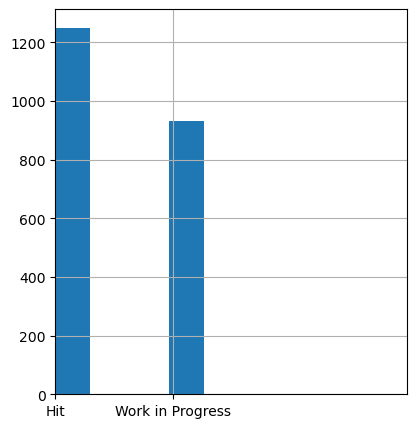

In [36]:
# Exploring the binning of the target variable
data['popularity_binned'].hist(bins=30, figsize=(10, 5), width=0.3, ax=plt.subplot(1, 2, 1))

plt.xlim(0, 3)

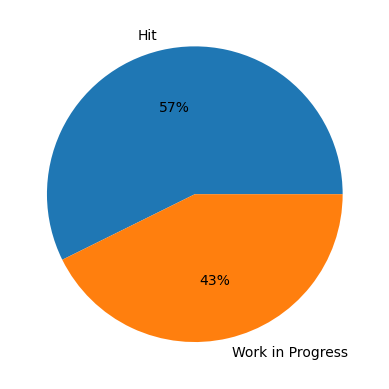

In [37]:
unique, counts = np.unique(data["popularity_binned"], return_counts=True)
plt.pie(counts, labels=unique, autopct='%.0f%%');

In [38]:
data.columns

Index(['year', 'track_popularity', 'artist_popularity', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'duration_ms', 'Melodic Energy', 'Emotional Tempo',
       'popularity_difference', 'popularity_binned'],
      dtype='object')

<Axes: >

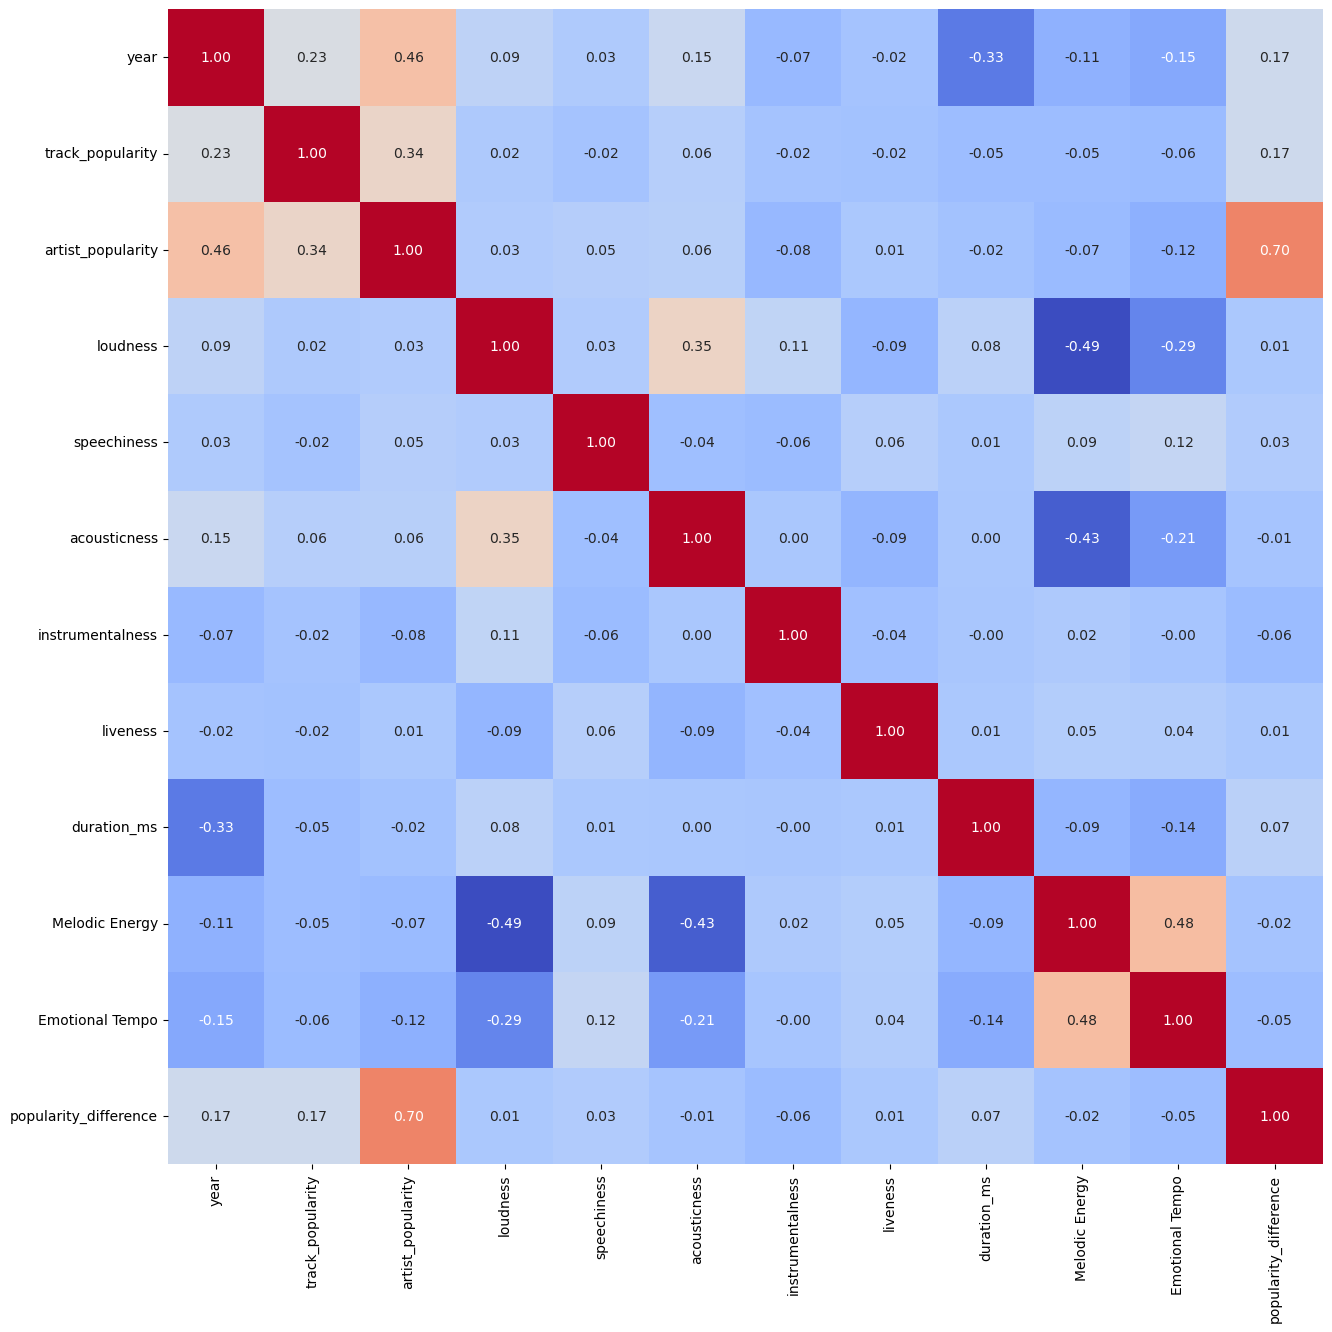

In [39]:
# Exploring the correlations between all features, both old and engineered new ones
plt.figure(figsize=(15, 15))
to_plot_corr = data.drop(['popularity_binned'], axis=1)
sns.heatmap(to_plot_corr.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=False, square=True)


#### Splitting the data for models

In [40]:
# Splitting the data into train and test

# Separate features from response field
X = data.drop(['popularity_binned', 'track_popularity'], axis=1)
y = data['popularity_binned']

# This encodes the target variable, y, into 0 and 1 (1 meaning Hit and 0 meaning Work in Progress)
encode = LabelEncoder()
y = encode.fit_transform(y)

# train test split with 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state= 123)

In [41]:
y_train.shape, y_test.shape 

((1744,), (437,))

## Random Forest model<a id="rf" />

We try first with Random Forest. This model has some features for consideration:
- Number of trees (estimators) does not impact overfitting
- Max features matters here (just bagging with number of features used for model limited)
- Must tune to find best hyperparameters:
    - 'max_depth': maximum number of levels in each decision tree
    - 'min_samples_leaf': minimum number of samples required to be at a leaf node
    - 'max_features': max features considered for each decision tree (we have 11 features total)

Potential scoring metrics:
- Accuracy: (TP + TN) / (TP + TN + FP + FN)
- f1 score = 2 * (precision * recall) / (precision + recall)
- roc_auc = Area under the ROC curve

Given our business model, we will choose the best metric to be the <b>F1 score</b>, given as it captures the interaction between precious and recall quite nicely.

In [42]:
# Setting the parameter for GridSearchCV to focus on accuracy score optimization
scorer = 'accuracy'

In [43]:
# Instantiate the RF model
rf = RandomForestClassifier(n_estimators=400, oob_score=True, random_state=123)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=400, oob_score=True, random_state=123)

Now we do a grid searching of best hyper parameters for Random Forest.

In [44]:
# grid search for best RF parameters
rf_params = {
    'max_depth': [4,5,6], # maximum number of levels in each decision tree
    'min_samples_leaf': [1,3,5,7], # minimum number of samples required to be at a leaf node
    'max_features': [8,9,10,11] # we have 10 features
    }
# Instantiate the grid search model with the RF model and the parameter grid
grid_rf = GridSearchCV(estimator = rf,
                     param_grid = rf_params,
                     cv=5,
                     scoring=scorer,
                     verbose=2)
# Fit the grid search to the data
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ....max_depth=4, max_features=8, min_samples_leaf=1; total time=   1.5s
[CV] END ....max_depth=4, max_features=8, min_samples_leaf=1; total time=   1.6s
[CV] END ....max_depth=4, max_features=8, min_samples_leaf=1; total time=   1.6s
[CV] END ....max_depth=4, max_features=8, min_samples_leaf=1; total time=   1.6s
[CV] END ....max_depth=4, max_features=8, min_samples_leaf=1; total time=   1.6s
[CV] END ....max_depth=4, max_features=8, min_samples_leaf=3; total time=   1.6s
[CV] END ....max_depth=4, max_features=8, min_samples_leaf=3; total time=   1.4s
[CV] END ....max_depth=4, max_features=8, min_samples_leaf=3; total time=   1.3s
[CV] END ....max_depth=4, max_features=8, min_samples_leaf=3; total time=   1.3s
[CV] END ....max_depth=4, max_features=8, min_samples_leaf=3; total time=   1.7s
[CV] END ....max_depth=4, max_features=8, min_samples_leaf=5; total time=   1.5s
[CV] END ....max_depth=4, max_features=8, min_s

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=400, oob_score=True,
                                              random_state=123),
             param_grid={'max_depth': [4, 5, 6], 'max_features': [8, 9, 10, 11],
                         'min_samples_leaf': [1, 3, 5, 7]},
             scoring='accuracy', verbose=2)

In [45]:
# Random Forest model with the best parameters found by GridSearchCV
random_forest_model = RandomForestClassifier(
    n_estimators = 400, random_state=123, #
    max_depth=grid_rf.best_params_['max_depth'], # from our grid search
    max_features=grid_rf.best_params_['max_features'], # from our grid search
    min_samples_leaf=grid_rf.best_params_['min_samples_leaf'], # from our grid search
    verbose=2) # verbose = 2 means that we want to see the output

# Fit the hyperparameter-tuned model to the training data
random_forest_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.7s finished


RandomForestClassifier(max_depth=5, max_features=8, min_samples_leaf=7,
                       n_estimators=400, random_state=123, verbose=2)

In [46]:
# Predictions for the training and testing sets
rf_test_pred = random_forest_model.predict(X_test)
rf_train_pred = random_forest_model.predict(X_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


In [47]:
# Accuracy scores for the training and testing sets
acc_rf_train= accuracy_score(y_train, rf_train_pred)
acc_rf_test = accuracy_score(y_test, rf_test_pred)

print("Train set Accuracy: %f " % (acc_rf_train))
print("Test set Accuracy: %f " % (acc_rf_test))

# AUC scores for the training and testing sets
roc_rf_train = roc_auc_score(y_train, rf_train_pred)
roc_rf_test = roc_auc_score(y_test, rf_test_pred)

print("Train set AUC: %f" % (roc_rf_train))
print("Test set AUC: %f" % (roc_rf_test))

# F1 scores for the training and testing sets
f1_rf_train = f1_score(y_train, rf_train_pred, average='macro')
f1_rf_test = f1_score(y_test, rf_test_pred, average='macro')

print("Train set F1: %f" % (f1_rf_train))
print("Test set F1: %f" % (f1_rf_test))

Train set Accuracy: 0.774656 
Test set Accuracy: 0.720824 
Train set AUC: 0.756960
Test set AUC: 0.697867
Train set F1: 0.761811
Test set F1: 0.701570


In [48]:
# Create a DataFrame to store the evaluation results
metrics_rf_df = pd.DataFrame({
    'Train': [acc_rf_train, roc_rf_train, f1_rf_train],
    'Test': [acc_rf_test, roc_rf_test, f1_rf_test]
}, index=['Accuracy', 'AUC', 'F1 Score'])

# Print the DataFrame
print(metrics_rf_df)

             Train      Test
Accuracy  0.774656  0.720824
AUC       0.756960  0.697867
F1 Score  0.761811  0.701570


In [49]:
# Classification report for the best XGBoost model
print(classification_report(y_test, rf_test_pred))

              precision    recall  f1-score   support

           0       0.73      0.84      0.78       255
           1       0.71      0.56      0.63       182

    accuracy                           0.72       437
   macro avg       0.72      0.70      0.70       437
weighted avg       0.72      0.72      0.71       437



When we run the model without hyperparameter tuning, it does worse. Hyperparameter tuning is essential to ensure our model is making the best choices to avoid overfitting.

We can display the most important features:


In [50]:
pd.Series(random_forest_model.feature_importances_, index = X.columns).sort_values(ascending = False)

artist_popularity        0.417694
year                     0.306164
popularity_difference    0.044037
acousticness             0.042393
loudness                 0.033851
duration_ms              0.033671
Melodic Energy           0.028978
Emotional Tempo          0.028901
speechiness              0.027978
liveness                 0.026114
instrumentalness         0.010218
dtype: float64

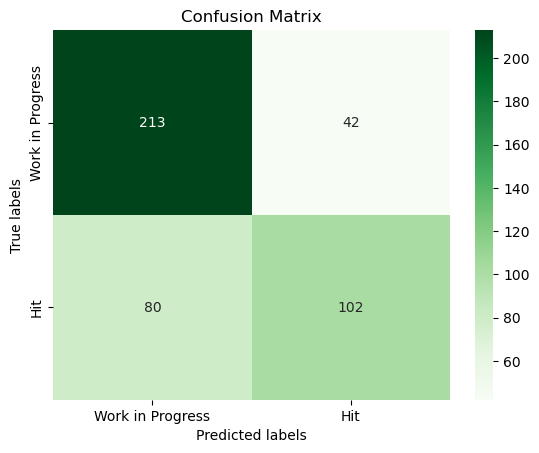

In [51]:
# Initialize the confusion matrix
cm = confusion_matrix(y_test, rf_test_pred)
ax= plt.subplot()
# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

# Setting labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Work in Progress', 'Hit']); ax.yaxis.set_ticklabels(['Work in Progress', 'Hit']);


## XGBoost model<a id="xgb" />

Let's attempt an XGBoost Regressor to see if we can get a better performance.

In [68]:
# Instantiate XGBoost model
model = XGBClassifier(n_estimators=200)
# Fit the model to the training data
model.fit(X_train, y_train)
scorer = 'accuracy'
# Parameters for GridSearchCV for XGBoost
params = {
        'subsample': [0.6, 0.8, 1.0], # the fraction of samples to be used for fitting the individual base learners
        'max_depth': [3, 5, 7], # maximum number of levels in each decision tree
        'learning_rate': [0.001, 0.01, 0.1] # step size shrinkage used to prevent overfitting
        }

# Instantiate the grid search model with the XGBoost model and the parameter grid
xgbGrid = GridSearchCV(model, params, cv = 5, scoring='roc_auc', verbose=1)
# Fit the grid search to the data
xgbGrid.fit(X_train, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 5, 7], 'subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [69]:
# fitting grid search to XGB model 
XGB_model = XGBClassifier(n_estimators = 200, random_state=123,
                            subsample=xgbGrid.best_params_['subsample'], # from our grid search
                            max_depth=xgbGrid.best_params_['max_depth'], # from our grid search
                            learning_rate=xgbGrid.best_params_['learning_rate'], # from our grid search
                            verbose=2) # verbose = 2 means that we want to see the output
XGB_model.fit(X_train, y_train)
# pred_train = XGB_model.predict(X_train)
# pred_test = XGB_model.predict(X_test)

/Users/nataliaclark/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[21:38:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [70]:
# Prediction using XGBoost model with the best parameters found by GridSearchCV
pred_train = XGB_model.predict_proba(X_train)[:, 1]
pred_test = XGB_model.predict_proba(X_test)[:, 1]

# Convert predicted probabilities to binary predictions (0 or 1) using a threshold of 0.5
pred_train_binary = (pred_train >= 0.5).astype(int)
pred_test_binary = (pred_test >= 0.5).astype(int)

In [71]:
# Accuracy scores for the training and testing sets
acc_boost_train = accuracy_score(y_train, pred_train_binary)
acc_boost_test = accuracy_score(y_test, pred_test_binary)

print("Attempt 1 Train Accuracy: %f" % (acc_boost_train))
print("Attempt 1 Test Accuracy: %f" % (acc_boost_test))

# AUC scores for the training and testing sets
roc_boost_train = roc_auc_score(y_train, pred_train)
roc_boost_test = roc_auc_score(y_test, pred_test)

print("Train set AUC: %f" % (roc_boost_train))
print("Test set AUC: %f" % (roc_boost_test))

f1_boost_train = f1_score(y_train, pred_train_binary)
f1_boost_test = f1_score(y_test, pred_test_binary)
print("F1 Score Train: ", f1_boost_train)
print("F1 Score Test: ", f1_boost_test)



Attempt 1 Train Accuracy: 0.749427
Attempt 1 Test Accuracy: 0.720824
Train set AUC: 0.824440
Test set AUC: 0.760267
F1 Score Train:  0.6630686198920586
F1 Score Test:  0.6139240506329114


In [72]:
# Create a DataFrame to store the evaluation results
metrics_boost_df = pd.DataFrame({
    'Train': [acc_boost_train, roc_boost_train, f1_boost_train],
    'Test': [acc_boost_test, roc_boost_test, f1_boost_test]
}, index=['Accuracy', 'AUC', 'F1'])

# Print the DataFrame
print(metrics_boost_df)

             Train      Test
Accuracy  0.749427  0.720824
AUC       0.824440  0.760267
F1        0.663069  0.613924


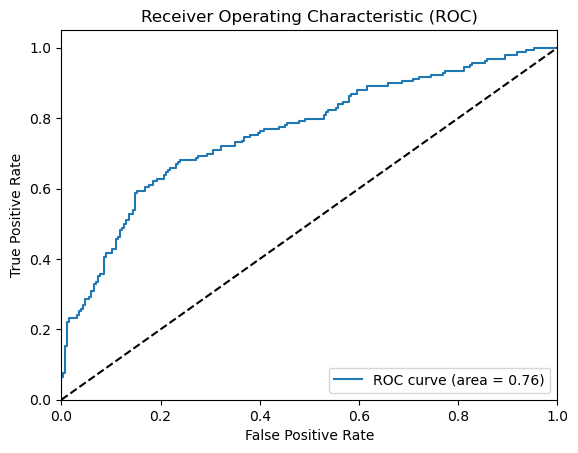

In [57]:
# Plot the ROC curve
# Initialize the plot
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
# Calculate the AUC
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_boost_test)
# Plot the diagonal line from (0, 1)
plt.plot([0, 1], [0, 1], 'k--')
# Set the limits of the plot for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# Set the labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')    
# Show the legend
plt.legend(loc="lower right")
# Show the plot
plt.show()

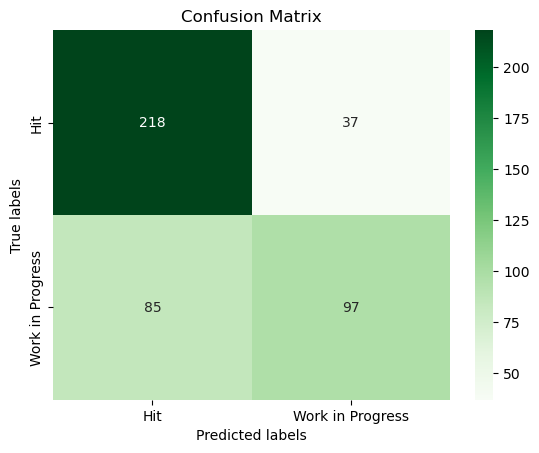

In [58]:
# Initialize the confusion matrix
cm = confusion_matrix(y_test, pred_test_binary)
ax= plt.subplot()
# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

# Setting labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Hit', 'Work in Progress']); ax.yaxis.set_ticklabels(['Hit', 'Work in Progress']);


In [59]:
# Finding feature importances from the best XGBoost model
feature_importances = XGB_model.feature_importances_

# Create a Series with feature importances as values and feature names as index
feature_importance_series = pd.Series(feature_importances, index=X.columns)

# Sort the Series by importance values in descending order
feature_importance_series_sorted = feature_importance_series.sort_values(ascending=False)

# Show the feature importances
print(feature_importance_series_sorted)


artist_popularity        0.239313
year                     0.231101
popularity_difference    0.084452
loudness                 0.071111
duration_ms              0.066785
Melodic Energy           0.057306
acousticness             0.054091
speechiness              0.050549
Emotional Tempo          0.049564
liveness                 0.048824
instrumentalness         0.046905
dtype: float32


In [60]:
# Classification report for the best XGBoost model
print(classification_report(y_test, pred_test_binary))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78       255
           1       0.72      0.53      0.61       182

    accuracy                           0.72       437
   macro avg       0.72      0.69      0.70       437
weighted avg       0.72      0.72      0.71       437



### Appendix: Considerations to follow thinking process

- Genre variable: it was referring to the artist, not the track itself. We considered a segmentation of the variable into groups, but when we tried with these variables, they did not add information to our model.
- Choosing a model: our data had outliers and not too many features, made sense to use a tree based model. We tried a simple Decision Tree, Bagging, Random Forest, and Boosting. Boosting seemed to consistently show us the best results, so we decided to use it. We have shown the code here for our 2 most successful models, seeing as we wanted to reduce the complexity of the notebook.
- Feature Engineering: How can we find more information in combinations of variables? We decided that danceability and energy could be multiplied, valence and tempo could be multiplied, and we could come up with a feature for the difference of the percentage of songs made by "popular artists" to the track's artists percentage of songs made. We set this threshold at the 75th percentile.
- What do we do with outliers?: Since we were deciding to use a tree-based model, we knew that outliers are implicitly handled well with these models. We did not worry about clipping them.
- Train/test split: 2300 records is not a lot - we want to have enough training data, but also reserve enough for testing.
- Overfitting: number of trees doesn't impact with most of these models, so we focused on the hyperparameters that would cause our model to overfit for each model and tried to tune on those.
- Computational complexity: considered, which is why we limited grid search parameters using logic and best judgment
- Feature importance: Seems to be artist popularity for all models tested. How can we turn this into a business approach to our problem?
- How do we choose an evaluation metric that best encapsulates our goal? How do we defend the accuracy numbers without undermining our model?